In [11]:
# IMPORT & LOAD LIBRARY + DATA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission_df = pd.read_csv("submission.csv")
print("Data Berhasil Terload")

# Simpan ID test_df untuk submission
test_ids = test_df['ID'] 

# Menambahkan kolos is_test di masing masing data
train_df['is_test'] = 0
test_df['is_test'] = 1

# Rename Electricity Consumption di train_df
train_df.rename(columns={'electricity_consumption_gwh': 'electricity_consumption'}, inplace=True)

# MERGING & RAPIHIN DATA TRAIN DAN TEST 

# Menggabungkan train_df dan test_df
test_df['electricity_consumption'] = np.nan
all_df = pd.concat([train_df.drop(columns=['ID']), test_df.drop(columns=['ID'])], ignore_index=True)

# Menampilkan informasi DataFrame
print("\n--- Kombinasi dua data (5 Baris Pertama) ---")
print(all_df.head())
print("\n--- Info Kombinasi dua data ---")
print(all_df.info())

# Mengconvert kolom 'date' ke tipe datetime
all_df['date'] = pd.to_datetime(all_df['date'])

# Sort & Tampilkan data berdasarkan tahunnya 
all_df = all_df.sort_values(by=['cluster_id', 'date']).reset_index(drop=True)
print("\n--- Data setelah diurutkan ---")
print(all_df.head())

Data Berhasil Terload

--- Kombinasi dua data (5 Baris Pertama) ---
         date cluster_id  electricity_consumption  temperature_2m_max  \
0  2014-01-01  cluster_1                  358.032                10.8   
1  2014-01-01  cluster_2                  548.247                12.2   
2  2014-01-01  cluster_3                  758.303                12.9   
3  2014-01-01  cluster_4                 1072.077                10.8   
4  2014-01-02  cluster_1                  386.908                10.7   

   temperature_2m_min  apparent_temperature_max  apparent_temperature_min  \
0                 4.2                       5.5                       0.4   
1                 4.3                       8.6                      -0.4   
2                -0.8                      10.1                      -4.9   
3                 4.7                       6.7                       0.6   
4                 7.0                       6.6                       3.3   

   sunshine_duration  daylight

In [ ]:
# FEATURE ENGINEERING 

# --- Time Based Features --- 
all_df['year'] = all_df['date'].dt.year
all_df['month'] = all_df['date'].dt.month
all_df['day'] = all_df['date'].dt.day
all_df['day_of_week'] = all_df['date'].dt.dayofweek
all_df['day_of_year'] = all_df['date'].dt.dayofyear
all_df['quarter'] = all_df['date'].dt.quarter
all_df['week_of_year'] = all_df['date'].dt.isocalendar().week.astype(int)

# Fitur Siklis untuk Waktu
# Menggunakan sin/cos untuk bulan dan hari dalam seminggu/tahun agar model memahami siklus
all_df['month_sin'] = np.sin(2 * np.pi * all_df['month'] / 12)
all_df['month_cos'] = np.cos(2 * np.pi * all_df['month'] / 12)
all_df['day_of_week_sin'] = np.sin(2 * np.pi * all_df['day_of_week'] / 7)
all_df['day_of_week_cos'] = np.cos(2 * np.pi * all_df['day_of_week'] / 7)
all_df['day_of_year_sin'] = np.sin(2 * np.pi * all_df['day_of_year'] / 365.25)
all_df['day_of_year_cos'] = np.cos(2 * np.pi * all_df['day_of_year'] / 365.25)

# --- Lag Features ---
print("\n--- Membuat Lag Features ---")
lag_periods = [1, 2, 3, 7, 14, 21, 28, 365]

for lag in lag_periods:
    all_df[f'consumption_lag_{lag}'] = all_df.groupby('cluster_id')['electricity_consumption'].shift(lag)

# --- Rolling Mean Features ---
print("--- Generating Rolling Mean Features for Weather Data ---")
rolling_features = [    'temperature_2m_max',
    'temperature_2m_min',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'sunshine_duration',
    'daylight_duration',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration']
rolling_periods = [3, 7]

for feature in rolling_features:
    for period in rolling_periods:
        all_df[f'{feature}_rollmean_{period}'] = all_df.groupby('cluster_id')[feature].transform(
            lambda x: x.rolling(window=period, min_periods=1).mean()
        )

        all_df[f'{feature}_rollmean_{period}'].fillna(all_df[feature], inplace=True)

# 3.4 Rolling Mean/Std Features for Electricity Consumption (SANGAT PENTING!)
print("--- Generating Rolling Mean/Std Features for Electricity Consumption ---")
# Rolling means dan std dev dari konsumsi listrik itu sendiri
consumption_rolling_periods = [3, 7, 14, 28] # Rata-rata 3, 7, 14, 28 hari sebelumnya

for period in consumption_rolling_periods:
    all_df[f'consumption_rollmean_{period}'] = all_df.groupby('cluster_id')['electricity_consumption'].transform(
        lambda x: x.rolling(window=period, min_periods=1).mean()
    )
    all_df[f'consumption_rollstd_{period}'] = all_df.groupby('cluster_id')['electricity_consumption'].transform(
        lambda x: x.rolling(window=period, min_periods=1).std()
    )
    # Imputasi NaN. Untuk std dev di awal akan NaN, bisa diisi 0 atau mean dari kolom itu
    all_df[f'consumption_rollmean_{period}'].fillna(all_df['electricity_consumption'], inplace=True)
    all_df[f'consumption_rollstd_{period}'].fillna(0, inplace=True) # std dev 0 jika hanya 1 data point

print("\nFeatures after engineering (5 Baris Pertama):")
print(all_df.head())
print("\nInfo after Feature Engineering:")
all_df.info()

In [ ]:
# SPLIT BACK DATA TRAIN DAN TEST
train_processed_df = all_df[all_df['is_test'] == 0].copy()
test_processed_df = all_df[all_df['is_test'] == 1].copy()

train_processed_df.drop(columns=['is_test'], inplace=True)
test_processed_df.drop(columns=['is_test'], inplace=True)

print(f"\nTrain processed shape: {train_processed_df.shape}")
print(f"Test processed shape: {test_processed_df.shape}")

for lag in lag_periods:
    col_name = f'consumption_lag_{lag}'
    mean_val = train_processed_df[col_name].mean()
    train_processed_df[col_name].fillna(mean_val, inplace=True)
    test_processed_df[col_name].fillna(mean_val, inplace=True)

print("\nMissing values di processed train data setelah lag imputation:")
print(train_processed_df.isnull().sum())
print("\nMissing values di processed test data setelah lag imputation (target should be NaN):")
print(test_processed_df.isnull().sum())

# Handle `cluster_id`
print("\n--- Handling Cluster ID ---")

le = LabelEncoder()
# Fit encoder on all unique cluster IDs from combined data to ensure consistency
all_cluster_ids = pd.concat([train_processed_df['cluster_id'], test_processed_df['cluster_id']]).unique()
le.fit(all_cluster_ids)

train_processed_df['cluster_id_encoded'] = le.transform(train_processed_df['cluster_id'])
test_processed_df['cluster_id_encoded'] = le.transform(test_processed_df['cluster_id'])

# Buang kolom 'cluster_id' asli (string), dan 'date' karena sudah diekstrak fiturnya
train_processed_df.drop(columns=['cluster_id', 'date'], inplace=True)
test_processed_df.drop(columns=['cluster_id', 'date'], inplace=True)

print("\nProcessed Train Data Head (after encoding and drop):")
print(train_processed_df.head())
print("\nProcessed Test Data Head (after encoding and drop):")
print(test_processed_df.head())


Training set size: 9350 rows
Validation set size: 2338 rows

--- Training LightGBM Model with Further Optimized Hyperparameters ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13389
[LightGBM] [Info] Number of data points in the train set: 9350, number of used features: 63
[LightGBM] [Info] Start training from score 549.211065

Training complete.

RMSE on Validation Set (Further Optimized Model): 24.2577


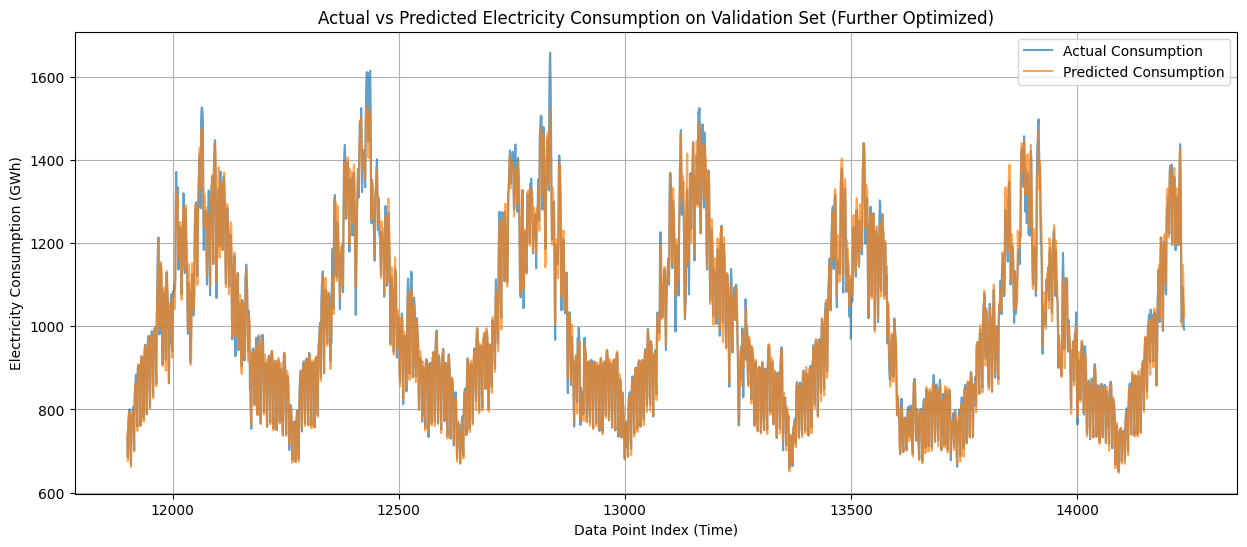

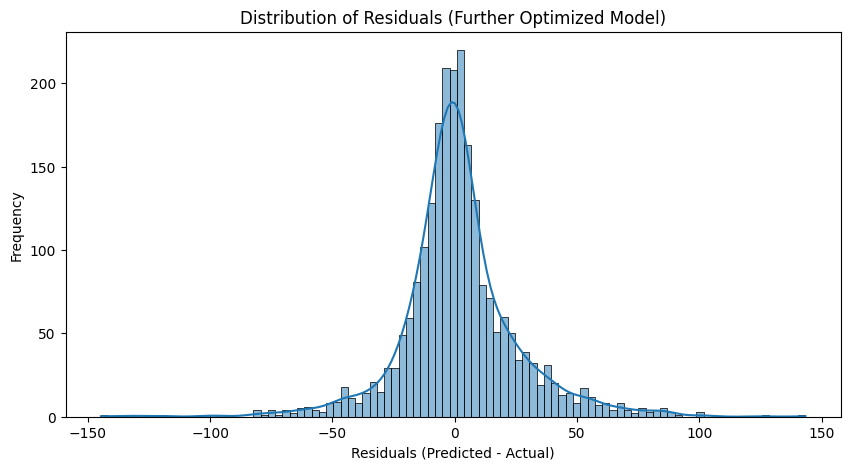

count    11688.000000
mean       642.313328
std        287.673473
min        207.472000
25%        414.376000
50%        602.672000
75%        836.034500
max       1658.348000
Name: electricity_consumption, dtype: float64


In [ ]:
# MODEL TRAINING (LIGHTGBM) & VALIDASI BERBASIS WAKTU ---

# Petakan features (X) dan target (y)
target_col = 'electricity_consumption'
features = [col for col in train_processed_df.columns if col != target_col]

X = train_processed_df[features]
y = train_processed_df[target_col]

# 4.1 Time-Series Validation Split
split_point = int(len(train_processed_df) * 0.8)

X_train, X_val = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_val = y.iloc[:split_point], y.iloc[split_point:]

print(f"\nTraining set size: {len(X_train)} rows")
print(f"Validation set size: {len(X_val)} rows")

# Inisialisasi model LightGBM dengan parameter yang LEBIH dioptimalkan
lgbm_model = lgb.LGBMRegressor(
    objective='regression',    # Tetap, optimalkan untuk MSE
    metric='rmse',             # Metrik evaluasi selama training
    n_estimators=10000,        # BERUBAH: Jauh lebih banyak pohon
    learning_rate=0.005,       # BERUBAH: Learning rate lebih kecil
    num_leaves=95,             # BERUBAH: Jumlah daun per pohon yang sedikit lebih tinggi
    max_depth=-1,              # Default, tidak ada batasan kedalaman
    min_child_samples=20,      # Default, jumlah sampel minimum di daun
    subsample=0.8,             # Tambahan: Bagging fraction, menggunakan 80% data untuk setiap pohon
    colsample_bytree=0.8,      # Tambahan: Feature fraction, menggunakan 80% fitur untuk setiap pohon
    reg_alpha=0.1,             # Tambahan: L1 regularization (Lasso)
    reg_lambda=0.1,            # Tambahan: L2 regularization (Ridge)
    random_state=42,           # Untuk hasil yang reproducible
    n_jobs=-1,                 # Menggunakan semua core CPU yang tersedia
)

print("\n--- Training LightGBM Model with Further Optimized Hyperparameters ---")
lgbm_model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(150, verbose=False)])

print("\nTraining complete.")

# 4.2 Evaluasi Model on Validation Set
predictions_val = lgbm_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
print(f"\nRMSE on Validation Set (Further Optimized Model): {rmse_val:.4f}")

# Visualisasi prediksi vs aktual
plt.figure(figsize=(15, 6))
plt.plot(y_val.index, y_val, label='Actual Consumption', alpha=0.7)
plt.plot(y_val.index, predictions_val, label='Predicted Consumption', alpha=0.7)
plt.title('Actual vs Predicted Electricity Consumption on Validation Set (Further Optimized)')
plt.xlabel('Data Point Index (Time)')
plt.ylabel('Electricity Consumption (GWh)')
plt.legend()
plt.grid(True)
plt.show()

# Visualisasi Residuals (Prediksi - Aktual)
residuals = predictions_val - y_val
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (Further Optimized Model)')
plt.xlabel('Residuals (Predicted - Actual)')
plt.ylabel('Frequency')
plt.show()


print(train_df['electricity_consumption'].describe())

In [ ]:
# MODELLING DAN PREDIKSI TEST DATA ---  

# Prediksi di Test Data ---
print("\n--- Predicting on Test Data ---")
test_predictions = lgbm_model.predict(test_processed_df[features])

# Pastikan prediksi tidak negatif (konsumsi listrik tidak mungkin negatif)
test_predictions[test_predictions < 0] = 0

# --- Membuat Submission File Sementara ---
submission_df = pd.DataFrame({'ID': test_ids, 'electricity_consumption': test_predictions})

test_original_df = pd.read_csv('test.csv') # Load ulang test.csv untuk akses ID aslinya
test_original_df['date'] = pd.to_datetime(test_original_df['date'])
test_original_df['formatted_id'] = test_original_df['cluster_id'].astype(str) + '_' + test_original_df['date'].dt.strftime('%Y-%m-%d')

submission_df = pd.DataFrame({
    'ID': test_original_df['formatted_id'],
    'electricity_consumption': test_predictions
})


# Menyimpan submission file di submission.csv
submission_df.to_csv('submission.csv', index=False)


--- Predicting on Test Data ---

Submission file created successfully: submission.csv
                     ID  electricity_consumption
0  cluster_1_2022-01-01               332.428551
1  cluster_2_2022-01-01               363.143889
2  cluster_3_2022-01-01               283.332928
3  cluster_4_2022-01-01               276.520962
4  cluster_1_2022-01-02               281.697307
